<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [2]:
##### Your Code Here #####
# raise Exception("\nThis task is not complete. \nReplace this line with your code for the task.")
from bs4 import BeautifulSoup as bs4
import requests

## 2) Use Spacy to tokenize / clean the listings 

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)
nlp = spacy.load("en_core_web_lg")

In [23]:
#Load csv
listings = pd.read_csv('data/job_listings.csv', index_col=0)

In [31]:
listings.shape

(426, 2)

In [24]:
listings.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [44]:
listings.description[4]

"b'<ul><li>Location: USA \\xe2\\x80\\x93 multiple locations</li>\\n<li>2+ years of Analytics experience</li>\\n<li>Understand business requirements and technical requirements</li>\\n<li>Can handle data extraction, preparation and transformation</li>\\n<li>Create and implement data models</li></ul>'"

In [71]:
soup = bs4(listings.description[0])

In [79]:
soup.get_text()

'b"Job Requirements:\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them\\nIntermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)\\nExposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R\\nAbility to communicate Model findings to both Technical and Non-Technical stake holders\\nHands on experience in SQL/Hive or similar programming language\\nMust show past work via GitHub, Kaggle or any other published article\\nMaster\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.\\nApply Now"'

In [62]:
def extract_description(df, col):
    desc = []
    for row in range(len(df[col])):
        soup = bs4(df[col][row])
        desc.append(soup.get_text())
    return desc
#     print(len(desc))
        

In [63]:
listings['processed'] = extract_description(listings, 'description')

In [99]:
listings.processed

0      b"Job Requirements:\nConceptual understanding ...
1      b'Job Description\n\nAs a Data Scientist 1, yo...
2      b'As a Data Scientist you will be working on c...
3      b'$4,969 - $6,756 a monthContractUnder the gen...
4      b'Location: USA \xe2\x80\x93 multiple location...
5      b'Create various Business Intelligence Analyti...
6      b'As Spotify Premium swells to over 96M subscr...
7      b"Everytown for Gun Safety, the nation's large...
8      b"MS in a quantitative discipline such as Stat...
9      b'Slack is hiring experienced data scientists ...
10     b'Who We Are\nBlackThorn Therapeutics is a com...
11     b'Part-timeAbout The Opportunity\nHere at Grub...
12     b"nfosys\xe2\x80\x93 Data & Analytics \xe2\x80...
13     b'As Spotify Premium swells to over 96M subscr...
14     b'Experience with guiding R&D strategy for you...
15     b'The Atlantic is seeking a Data Scientist to ...
16     b'THE CHALLENGE\nEventbrite is big, bustling m...
17     b'ContractWe are looking

In [149]:
# doc = nlp(listings['processed'])
tokens = []

for doc in tokenizer.pipe(listings['processed']):
    doc_tokens = [token.text.lower() for token in doc if (token.is_stop==False) & (token.is_punct==False) & (token.is_space==False)]
    tokens.append(doc_tokens)

In [150]:
listings['tokens'] = tokens

In [151]:
listings.head()

,description,title,processed,tokens
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""Job Requirements:\nConceptual understanding ...","[b""job, requirements:\nconceptual, understandi..."
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo...","[b'job, description\n\nas, data, scientist, 1,..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...,"[b'as, data, scientist, working, consulting, b..."
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen...","[b'$4,969, $6,756, monthcontractunder, general..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...,"[b'location:, usa, \xe2\x80\x93, multiple, loc..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [152]:
vect = CountVectorizer()

In [157]:
vect.fit_transform(listings['tokens'].apply(lambda x: " ".join(x)))

<426x9992 sparse matrix of type '<class 'numpy.int64'>'
	with 99812 stored elements in Compressed Sparse Row format>

In [158]:
print(dtm)

  (0, 225)	1
  (0, 496)	1
  (0, 563)	2
  (0, 654)	1
  (0, 668)	1
  (0, 690)	1
  (0, 748)	1
  (0, 907)	1
  (0, 1059)	1
  (0, 1458)	1
  (0, 1514)	1
  (0, 1598)	1
  (0, 1675)	1
  (0, 2056)	1
  (0, 2117)	1
  (0, 2152)	1
  (0, 2466)	1
  (0, 2597)	1
  (0, 2828)	1
  (0, 2936)	2
  (0, 2953)	1
  (0, 3109)	1
  (0, 3136)	1
  (0, 3225)	1
  (0, 3242)	1
  :	:
  (425, 9531)	1
  (425, 9567)	1
  (425, 9587)	1
  (425, 9623)	1
  (425, 9644)	1
  (425, 9692)	1
  (425, 9715)	2
  (425, 9752)	1
  (425, 9756)	1
  (425, 9757)	1
  (425, 9762)	2
  (425, 9773)	3
  (425, 9775)	1
  (425, 9789)	10
  (425, 9791)	2
  (425, 9801)	6
  (425, 9807)	1
  (425, 9810)	1
  (425, 9813)	1
  (425, 9835)	5
  (425, 9848)	2
  (425, 9884)	3
  (425, 9952)	5
  (425, 9965)	2
  (425, 9976)	3


In [159]:
sum_words = dtm.sum(axis=0)

In [160]:
words_freq = [(word, sum_words[0, idx]) for word, idx in     vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [163]:
print(words_freq[:10])

[('and', 11737), ('to', 6913), ('the', 5300), ('of', 4611), ('data', 4394), ('in', 3594), ('with', 3059), ('for', 2059), ('or', 1936), ('you', 1505)]


## 4) Visualize the most common word counts

In [166]:
import squarify
from collections import Counter

In [167]:
def count(docs):
    
    word_counts = Counter()
    appears_in = Counter()
    total_docs = len(docs)
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))
    
    counts = zip(word_counts.keys(), word_counts.values())
    wc = pd.DataFrame(counts, columns = ['word', 'count'])
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()
    appearances = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(appearances, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [171]:
counts = count(listings['tokens'])

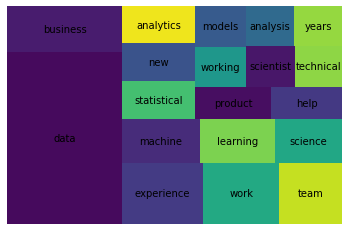

In [172]:
top20 = counts[counts['rank'] < 20]

squarify.plot(sizes=top20['pct_total'], label=top20['word'])
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [179]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', min_df=0.025, max_df=.98, ngram_range=(1,2))

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(listings['tokens'].apply(lambda x: " ".join(x)))

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
dtm.head()

,000,10,100,12,15,20,2019,25,3rd,40,...,years data,years experience,years hands,years industry,years professional,years relevant,years work,years xe2,york,york city
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [180]:
from sklearn.neighbors import NearestNeighbors

In [181]:
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [185]:
nn.kneighbors([dtm.iloc[2].values])

(array([[0.        , 1.25955418, 1.26517326, 1.27291236, 1.27640718]]),
 array([[  2, 307, 190, 407,  52]]))

In [186]:
listings['processed'][2]

"b'As a Data Scientist you will be working on consulting side of our business. You will be responsible for analyzing large, complex datasets and identify meaningful patterns that lead to actionable recommendations. You will be performing thorough testing and validation of models, and support various aspects of the business with data analytics.\\nAbility to do statistical modeling, build predictive models and leverage machine learning algorithms.\\nThis position will combine the typical Data Scientist math and analytical skills, with research, advanced business, communication, and presentation skills.\\nPrimary job location is in Sacramento, but work-from-home option is available.\\n\\nQualifications\\nBachelors, MS or PhD in a relevant field (Computer Science, Engineering, Statistics, Physics, Applied Math)\\nExperience in R and/or Python is preferred'"

In [187]:
listings['processed'][307]

"b'Job Description\\n\\nToomey Technologies has immediate openings for talented and motivated Data Scientists in Northern Virginia.\\nOur solutions require integrated models based on large and varied datasets, feeding analytic applications so that we can extract patterns and behaviors obscured within the data to augment the capabilities of human operators. We need data scientists/software engineers of all experience levels to staff positions supporting the defense and intelligence communities. This is a unique position where you will not only analyze the data, but also integrate your algorithms and visualizations into production systems. The Data Scientist will be working on a project to leverage commercial and open source data streams fused with classified intelligence to increase indications and warning (I&W) data and to provide automated resource allocation and response options to include support for object detection. The Data Scientist will work as part of an agile software develop

In [195]:
search = ["""
Hi-Rez Studios is now accepting qualified Machine Learning Engineering Intern applicants for our Summer Internship Program at our studio in Alpharetta, Georgia on our Platforms team!

This will be a paid, seasonal employee. The deadline to submit all application materials is Feb 28, 2020. Internship selections will be made and announced by April 1, 2020, with the Intern work program starting mid-May, 2020, ending mid-August, 2020 (actual dates to be determined).

Come join the creator of the critically acclaimed SMITE; Paladins; Realm Royale; Tribes: Ascend; and Global Agenda as we embark on exciting new game projects!
What our Machine Learning Engineering Interns do:
Use and customize state of the art machine learning algorithms to apply to Hi-Rez data in areas such as matchmaking, customer value, game play, in game AI, and customer retention.
Assist with producing hypotheses from machine learning results to test in the game.
Iterate and refine data components captured by our games.
What we are looking for:
Must be able to travel effectively to and from studio on a daily basis.
Must be currently enrolled in (documented as a "Junior" or higher grade level) - or recently graduated of - an accredited college, university, or school of art.
At least one professional Letter of Reference from a manager, supervisor, professor or instructor; outlining how they know you, and why you should be considered for this position.
Current resume.
Cover letter.
Authorized to work in the U.S.
Good communication skills, and a team player.
Even better candidates:
Loves games / experience in gaming industry.
Degree with focus on machine learning.
Have experience in SQL.
Have experience using Python, R, or comparable system to analyze large data sets."""]

In [196]:
new = tfidf.transform(search)
new

<1x2590 sparse matrix of type '<class 'numpy.float64'>'
	with 86 stored elements in Compressed Sparse Row format>

In [197]:
nn.kneighbors(new.todense())

(array([[1.19784088, 1.2069082 , 1.23104202, 1.23573847, 1.2539735 ]]),
 array([[121, 290,  53, 201,  30]]))

In [198]:
listings['processed'][121]

"b'Part-timeThe Nittany Artificial Intelligence (AI) Alliance at The Pennsylvania State University (PSU) is looking for a talented and highly motivated undergraduate intern to work on AI-related projects, gaining hands-on experience that enhances their learning at Penn State, while also gaining highly marketable development experience. Selected candidates will be members of a software development team and assist with the development of prototypes leveraging artificial intelligence and the design and configuration of cognitive modules within existing cognitive agents. We are looking for a Data Science intern to join our team beginning Summer 2019. As a Data Science Intern, you will collaborate with the other software development team members to do meaningful work while also growing your expertise. Strong consideration will be given to candidates who can present a successful project in machine learning that demonstrates the ability to create and train end-to-end solutions combining data 

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 